# 👥 Customer Segmentation Analysis
## RFM Analysis + K-Means Clustering

**Business Goal:** Segment customers into distinct groups based on purchasing behavior to enable targeted marketing strategies.

**Techniques:**
- **RFM Analysis**: Recency, Frequency, Monetary value
- **K-Means Clustering**: Group similar customers
- **PCA**: Visualize high-dimensional customer data

**Use Cases:**
- Target high-value customers with premium offers
- Re-engage churned customers
- Personalize marketing campaigns by segment

## 1. Import Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Snowflake
import snowflake.connector
import toml
from datetime import datetime, timedelta

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Load Customer Transaction Data

In [13]:
# Connect to Snowflake
secrets = toml.load("../streamlit/.streamlit/secrets.toml")

conn = snowflake.connector.connect(
    user=secrets['snowflake']['user'],
    password=secrets['snowflake']['password'],
    account=secrets['snowflake']['account'],
    warehouse=secrets['snowflake']['warehouse'],
    database=secrets['snowflake']['database'],
    schema=secrets['snowflake']['schema']
)

# Load customer transaction data
# Note: Using ENTITY as proxy for customer since FINANCIAL_TRANSACTIONS doesn't have CUSTOMER_ID
# We'll aggregate by entity (business entity) as "customers"
query = """
SELECT 
    ENTITY AS CUSTOMER_ID,
    TRANSACTION_DATE,
    AMOUNT,
    REGION,
    TRANSACTION_TYPE,
    ACCOUNT_CODE
FROM SILVER.FINANCIAL_TRANSACTIONS_CLEAN
WHERE TRANSACTION_TYPE = 'Sale'
AND ENTITY IS NOT NULL
AND AMOUNT > 0
ORDER BY ENTITY, TRANSACTION_DATE
"""

df_transactions = pd.read_sql(query, conn)
conn.close()

print(f"✅ Loaded {len(df_transactions):,} transactions")
print(f"📊 Unique customers (entities): {df_transactions['CUSTOMER_ID'].nunique():,}")
print(f"📅 Date range: {df_transactions['TRANSACTION_DATE'].min()} to {df_transactions['TRANSACTION_DATE'].max()}")
print(f"💰 Total amount: ${df_transactions['AMOUNT'].sum():,.2f}")

✅ Loaded 984 transactions
📊 Unique customers (entities): 947
📅 Date range: 2010-01-03 to 2023-12-26
💰 Total amount: $4,928,697.46


## 3. Calculate RFM Metrics

**RFM Analysis:**
- **Recency**: Days since last purchase
- **Frequency**: Number of purchases
- **Monetary**: Total amount spent

In [14]:
# Calculate reference date (most recent transaction + 1 day)
reference_date = df_transactions['TRANSACTION_DATE'].max() + pd.Timedelta(days=1)

# Calculate RFM metrics for each customer
rfm = df_transactions.groupby('CUSTOMER_ID').agg({
    'TRANSACTION_DATE': lambda x: (reference_date - x.max()).days,  # Recency
    'CUSTOMER_ID': 'count',  # Frequency
    'AMOUNT': 'sum'  # Monetary
}).rename(columns={
    'TRANSACTION_DATE': 'Recency',
    'CUSTOMER_ID': 'Frequency',
    'AMOUNT': 'Monetary'
})

# Add additional behavioral metrics
rfm['AvgPurchaseValue'] = rfm['Monetary'] / rfm['Frequency']
rfm['DaysSinceFirstPurchase'] = df_transactions.groupby('CUSTOMER_ID')['TRANSACTION_DATE'].apply(
    lambda x: (reference_date - x.min()).days
)

print("✅ RFM Metrics Calculated")
print(f"\n📊 RFM Summary:")
display(rfm.describe().round(2))

✅ RFM Metrics Calculated

📊 RFM Summary:


,Recency,Frequency,Monetary,AvgPurchaseValue,DaysSinceFirstPurchase
count,947.00,947.00,947.00,947.00,947.00
mean,2544.17,1.04,5204.54,5023.39,2604.12
std,1482.78,0.24,3118.19,2884.64,1480.29
min,1.00,1.00,12.20,12.20,1.00
25%,1258.00,1.00,2552.20,2468.26,1364.00
50%,2475.00,1.00,5109.91,5000.14,2576.00
75%,3846.00,1.00,7625.61,7454.80,3943.00
max,5106.00,5.00,21211.04,9993.96,5106.00


## 4. Standardize Features & Apply K-Means Clustering

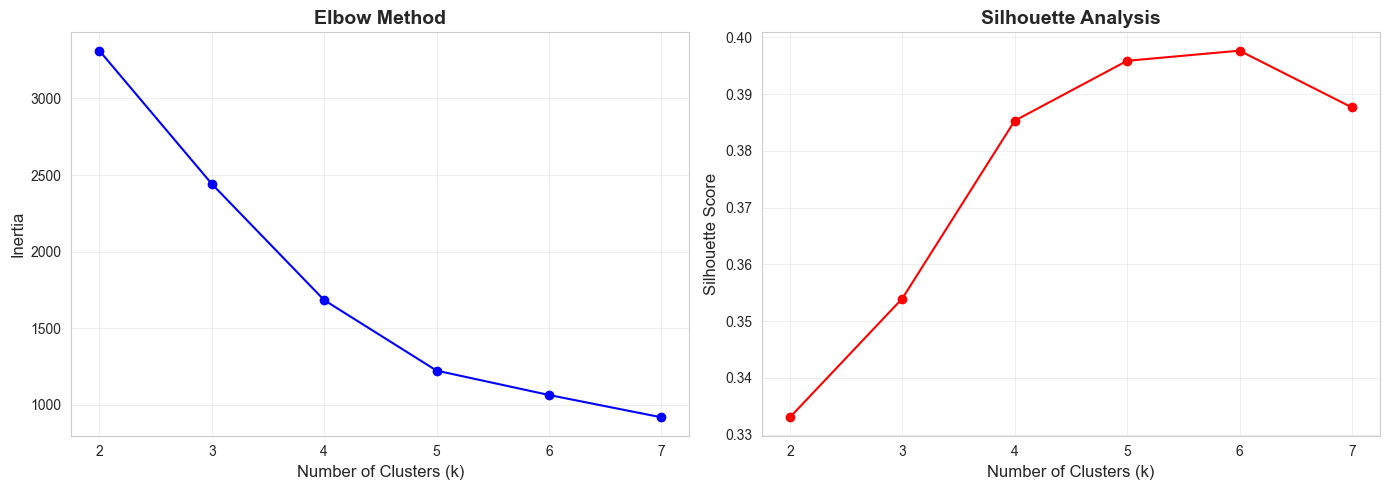


✅ Optimal number of clusters: 6
📊 Best Silhouette Score: 0.398


In [15]:
# Standardize features (important for K-Means)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Find optimal number of clusters using Elbow Method & Silhouette Score
inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal number of clusters: {optimal_k}")
print(f"📊 Best Silhouette Score: {max(silhouette_scores):.3f}")

In [16]:
# Apply K-Means with optimal clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Segment'] = kmeans_final.fit_predict(rfm_scaled)

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

print(f"✅ Clustering complete!")
print(f"📊 PCA Explained Variance: {pca.explained_variance_ratio_.sum():.1%}")
print(f"\n🎯 Segment Distribution:")
print(rfm['Segment'].value_counts().sort_index())

✅ Clustering complete!
📊 PCA Explained Variance: 79.0%

🎯 Segment Distribution:
Segment
0    238
1    243
2    223
3     30
4      1
5    212
Name: count, dtype: int64


## 5. Visualize Customer Segments

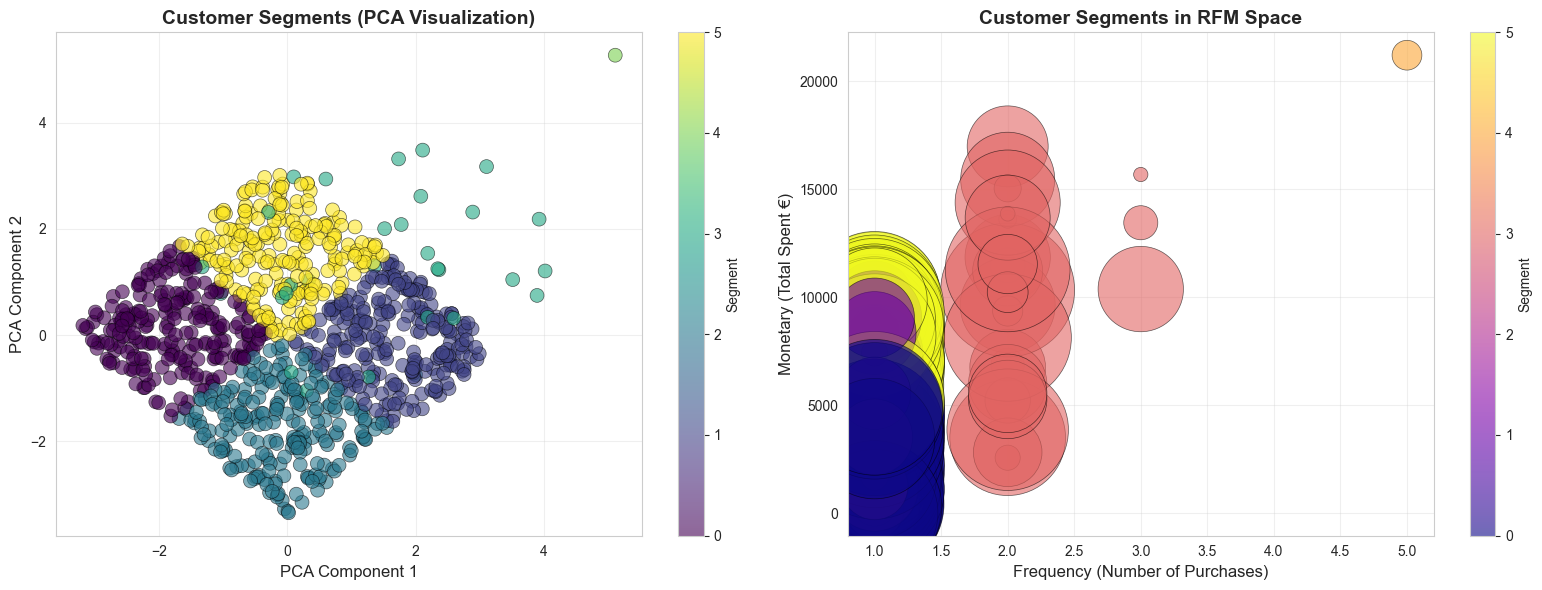


📊 Visualization Tips:
• Left plot: Segments separated by PCA (reduced dimensions)
• Right plot: Frequency vs Monetary, bubble size = Recency
• Different colors = Different customer segments


In [17]:
# Visualizations using matplotlib (more reliable for Jupyter)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 2D PCA visualization
scatter = axes[0].scatter(rfm['PCA1'], rfm['PCA2'], c=rfm['Segment'], 
                          cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('PCA Component 1', fontsize=12)
axes[0].set_ylabel('PCA Component 2', fontsize=12)
axes[0].set_title('Customer Segments (PCA Visualization)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Segment')

# RFM 3D representation (2D projection: Frequency vs Monetary colored by Recency)
scatter2 = axes[1].scatter(rfm['Frequency'], rfm['Monetary'], 
                           c=rfm['Segment'], cmap='plasma', 
                           s=rfm['Recency']*2, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Frequency (Number of Purchases)', fontsize=12)
axes[1].set_ylabel('Monetary (Total Spent €)', fontsize=12)
axes[1].set_title('Customer Segments in RFM Space', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Segment')

plt.tight_layout()
plt.show()

print("\n📊 Visualization Tips:")
print("• Left plot: Segments separated by PCA (reduced dimensions)")
print("• Right plot: Frequency vs Monetary, bubble size = Recency")
print("• Different colors = Different customer segments")

## 6. Partie 3.4 - Évaluation & Interprétation

In [18]:
# 1. Performance Metrics
print("="*70)
print("📊 ÉVALUATION DES PERFORMANCES")
print("="*70)

silhouette = silhouette_score(rfm_scaled, rfm['Segment'])
davies_bouldin = davies_bouldin_score(rfm_scaled, rfm['Segment'])

print(f"\n✅ Silhouette Score: {silhouette:.3f}")
print(f"   → Plus proche de 1 = meilleure séparation des clusters")
print(f"   → Score > 0.5 indique une bonne segmentation")

print(f"\n✅ Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"   → Plus proche de 0 = meilleurs clusters")
print(f"   → Score < 1.0 indique une bonne segmentation")

print(f"\n✅ Inertie: {kmeans_final.inertia_:.2f}")
print(f"   → Mesure de la compacité des clusters")

# 2. Segment Profiles
print("\n" + "="*70)
print("🎯 INTERPRÉTATION - PROFIL DES SEGMENTS")
print("="*70)

segment_profiles = rfm.groupby('Segment')[['Recency', 'Frequency', 'Monetary', 'AvgPurchaseValue']].mean().round(2)
display(segment_profiles)

# Label segments based on characteristics
segment_labels = {}
for seg in segment_profiles.index:
    if segment_profiles.loc[seg, 'Monetary'] > segment_profiles['Monetary'].median() and \
       segment_profiles.loc[seg, 'Frequency'] > segment_profiles['Frequency'].median():
        segment_labels[seg] = "🌟 VIP Champions"
    elif segment_profiles.loc[seg, 'Recency'] < segment_profiles['Recency'].median() and \
         segment_profiles.loc[seg, 'Frequency'] > segment_profiles['Frequency'].median():
        segment_labels[seg] = "💎 Loyal Customers"
    elif segment_profiles.loc[seg, 'Recency'] > segment_profiles['Recency'].median() * 1.5:
        segment_labels[seg] = "😴 At Risk / Dormant"
    elif segment_profiles.loc[seg, 'Frequency'] == segment_profiles['Frequency'].min():
        segment_labels[seg] = "🆕 New Customers"
    else:
        segment_labels[seg] = "⭐ Potential Loyalists"

rfm['Segment_Label'] = rfm['Segment'].map(segment_labels)

print("\n📋 Segment Labels:")
for seg, label in segment_labels.items():
    count = (rfm['Segment'] == seg).sum()
    pct = count / len(rfm) * 100
    print(f"   Segment {seg}: {label} - {count} customers ({pct:.1f}%)")

📊 ÉVALUATION DES PERFORMANCES

✅ Silhouette Score: 0.398
   → Plus proche de 1 = meilleure séparation des clusters
   → Score > 0.5 indique une bonne segmentation

✅ Davies-Bouldin Index: 0.662
   → Plus proche de 0 = meilleurs clusters
   → Score < 1.0 indique une bonne segmentation

✅ Inertie: 1064.60
   → Mesure de la compacité des clusters

🎯 INTERPRÉTATION - PROFIL DES SEGMENTS


,Recency,Frequency,Monetary,AvgPurchaseValue
Segment,,,,
0,3938.20,1.0,2579.44,2579.44
1,1312.49,1.0,7701.85,7701.85
2,1344.09,1.0,2494.26,2494.26
3,1578.80,2.1,9866.01,4713.50
4,230.00,5.0,21211.04,4242.21
5,3800.83,1.0,7404.85,7404.85



📋 Segment Labels:
   Segment 0: 😴 At Risk / Dormant - 238 customers (25.1%)
   Segment 1: 🆕 New Customers - 243 customers (25.7%)
   Segment 2: 🆕 New Customers - 223 customers (23.5%)
   Segment 3: 🌟 VIP Champions - 30 customers (3.2%)
   Segment 4: 🌟 VIP Champions - 1 customers (0.1%)
   Segment 5: 😴 At Risk / Dormant - 212 customers (22.4%)


## 7. Recommandations Marketing Concrètes

In [19]:
print("="*70)
print("💡 RECOMMANDATIONS MARKETING PAR SEGMENT")
print("="*70)

recommendations = {
    "🌟 VIP Champions": {
        "Caractéristiques": "Achètent fréquemment, dépensent beaucoup, actifs récemment",
        "Actions": [
            "✓ Programme de fidélité premium avec avantages exclusifs",
            "✓ Accès anticipé aux nouveaux produits",
            "✓ Offres personnalisées haut de gamme",
            "✓ Service client prioritaire"
        ],
        "Budget": "Élevé",
        "Objectif": "Rétention et maximisation de la valeur à vie"
    },
    "💎 Loyal Customers": {
        "Caractéristiques": "Achètent régulièrement, actifs, valeur moyenne",
        "Actions": [
            "✓ Programmes de parrainage avec récompenses",
            "✓ Offres de cross-sell basées sur l'historique",
            "✓ Communication régulière par email",
            "✓ Proposer upgrade vers segment VIP"
        ],
        "Budget": "Moyen-Élevé",
        "Objectif": "Augmenter la fréquence et le panier moyen"
    },
    "😴 At Risk / Dormant": {
        "Caractéristiques": "N'ont pas acheté récemment, risque de churn",
        "Actions": [
            "✓ Campagne de réactivation avec remise importante (20-30%)",
            "✓ Email 'We miss you' personnalisé",
            "✓ Enquête de satisfaction pour comprendre l'inactivité",
            "✓ Offre limitée dans le temps pour créer urgence"
        ],
        "Budget": "Faible-Moyen",
        "Objectif": "Réengagement avant perte définitive"
    },
    "🆕 New Customers": {
        "Caractéristiques": "Premiers achats récents, peu de transactions",
        "Actions": [
            "✓ Programme d'onboarding avec guide produits",
            "✓ Offre de bienvenue sur 2ème achat (-15%)",
            "✓ Contenu éducatif sur les produits bio",
            "✓ Collecte de préférences pour personnalisation future"
        ],
        "Budget": "Moyen",
        "Objectif": "Conversion en clients réguliers"
    },
    "⭐ Potential Loyalists": {
        "Caractéristiques": "Comportement prometteur, potentiel de croissance",
        "Actions": [
            "✓ Incitations à augmenter la fréquence d'achat",
            "✓ Offres groupées (bundle deals)",
            "✓ Programme de points de fidélité",
            "✓ Communication sur la diversité des produits"
        ],
        "Budget": "Moyen",
        "Objectif": "Accélération vers segment Loyal"
    }
}

for segment, details in recommendations.items():
    print(f"\n{'─'*70}")
    print(f"{segment}")
    print(f"{'─'*70}")
    print(f"\n📊 {details['Caractéristiques']}")
    print(f"\n💰 Budget recommandé: {details['Budget']}")
    print(f"🎯 Objectif: {details['Objectif']}")
    print(f"\n🚀 Actions prioritaires:")
    for action in details['Actions']:
        print(f"   {action}")

print("\n" + "="*70)
print("📈 IMPACT BUSINESS ATTENDU")
print("="*70)
print("""
✓ Rétention clients: +15-25% sur segments à risque
✓ Valeur vie client (LTV): +30% sur VIP Champions
✓ Taux de conversion: +20% sur nouveaux clients
✓ Churn rate: -10-15% grâce à la réactivation ciblée
✓ ROI marketing: +40% par personnalisation des campagnes
""")

💡 RECOMMANDATIONS MARKETING PAR SEGMENT

──────────────────────────────────────────────────────────────────────
🌟 VIP Champions
──────────────────────────────────────────────────────────────────────

📊 Achètent fréquemment, dépensent beaucoup, actifs récemment

💰 Budget recommandé: Élevé
🎯 Objectif: Rétention et maximisation de la valeur à vie

🚀 Actions prioritaires:
   ✓ Programme de fidélité premium avec avantages exclusifs
   ✓ Accès anticipé aux nouveaux produits
   ✓ Offres personnalisées haut de gamme
   ✓ Service client prioritaire

──────────────────────────────────────────────────────────────────────
💎 Loyal Customers
──────────────────────────────────────────────────────────────────────

📊 Achètent régulièrement, actifs, valeur moyenne

💰 Budget recommandé: Moyen-Élevé
🎯 Objectif: Augmenter la fréquence et le panier moyen

🚀 Actions prioritaires:
   ✓ Programmes de parrainage avec récompenses
   ✓ Offres de cross-sell basées sur l'historique
   ✓ Communication régulière par 